In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

from torchsummary import summary
import segmentation_models_pytorch as smp

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import glob
import json
import base64
import random

import os
import shutil
import string
import math


from PIL import Image, ImageDraw, ImageFont

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
IMAGE_PATH = 'images/'
MASK_PATH = 'masks_new/'
JSON_FOLDER = 'train/object_detection/'
N_CLASSES = 4

In [3]:
!nvidia-smi

Fri Nov 25 19:34:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
|  0%   43C    P8     8W / 200W |      2MiB /  8119MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:02:00.0 Off |                  N/A |
| 53%   

### Препроцессинг данных

In [4]:
# из json файлов получаем схемы квартир и маски к ним

def decode_image(encoded_image: str) -> np.ndarray:
    bytearray_ = np.asarray(bytearray(base64.b64decode(encoded_image)), dtype=np.uint8)
    return cv2.imdecode(bytearray_, cv2.IMREAD_COLOR).astype(np.float32) / 255

def get_images_with_mask(json_fld, image_fld, mask_fld):

    # i = 0
    for file in list(glob.glob(json_fld + "*.json")):

        if file.startswith('..') or filename.endswith('checkpoint.png'):
            continue
        with open(file, 'r') as f:
            json_contents = json.load(f)
        image = decode_image(json_contents['imageData'])
        cv2.imwrite(image_fld + json_contents['imagePath'], image*255.0)
        image.fill(0)

        imageHeight = json_contents['imageHeight']
        imageWidth = json_contents['imageWidth']
        shapes = json_contents['shapes']

        colors = {'wall':(0, 0, 1), 'window' : (0,0,2), 'door': (0,0,3)}
        for i in range(len(shapes)):
            label = shapes[i]['label']
            if label in ['door', 'window', 'wall', 'wall_common', 'door_common', 'window_common', 
                        'wall_balcony' , 'door_balcony', 'window_balcony']:
                if label in ['wall_common', 'door_common', 'window_common', 'wall_balcony' , 
                             'door_balcony', 'window_balcony']:
                    label = label.split('_')[0]
                points = shapes[i]['points']
                if len(points) < 2:
                    continue

                if shapes[i]['shape_type'] == 'rectangle':
                    cv2.rectangle(image, np.int32(points[0]), np.int32(points[1]), colors[label], thickness= -1)
                else:
                    cv2.fillPoly(image, np.int32([points]), colors[label])

        cv2.imwrite(mask_fld + json_contents['imagePath'], image[:, :, 2])

In [5]:
fonts_list = [
    'Ubuntu-n1M0.ttf',
    'Blink-ynYZ.otf',
    'Passageway-8qzz.otf',
    'HussarBoldWebEdition-xq5O.otf',
    'ClearSans-OP0p.ttf',
    'HappyTime-D6AD.otf',
    'Blanket-Mw5B.otf',
    'NumbbunnySemibold-3r53.otf',
    'Nordicablack-Xa39.otf',
    'Hussar3dTwo-1qPL.otf',
    'HiTall-2YGl.otf',
    'HiTallObl-vOJ7.otf'
]

In [6]:
# additional augmentations

def aug_black_stripes(img):
    w = img.shape[0]
    h = img.shape[1]
    w_stripes_1 = random.randint(5, 300)
    w_stripes_2 = random.randint(5, 300)
    aug_img = img.copy()
    
    if np.all(img[0 :w_stripes_1, :] ==  255):
        aug_img[0 :w_stripes_1, :].fill(0)
        
    if np.all(img[ w-w_stripes_2:w, :] ==  255):
        aug_img[ w-w_stripes_2:w, :].fill(0)

    return aug_img if not (aug_img == img).all() else None

def aug_text(img):
    #Creating draw object
    draw = ImageDraw.Draw(img) 

    #Creating text and font object
    text = ''.join([random.choice(string.ascii_letters +
                                  'АаБбВвГгДдЕеЁёЖжЗзИиЙйКкЛлМмНнОоПпРрСсТтУуФфХхЦцЧчШшЩщЪъЫыЬьЭэЮюЯя') for _ in range(6)])
    font = random.choice(fonts_list)
    font = ImageFont.truetype(font, random.randint(10, 120))
   
    #Positioning Text
    textwidth, textheight = draw.textsize(text, font)
    width, height = img.size 
    x=random.randint(0, width)
    y=random.randint(0, height)

    #Applying text on image via draw object
    color = list(np.random.choice(range(256), size=3))
    draw.text((x, y), text, font=font, fill=tuple(color))
    return img

from PIL import Image, ImageDraw


# Draw white rectangle and ellipse

def aug_dotted(img):
    w, h = img.size
    w_stripes_1 = random.randint(0, w)
    w_stripes_2 = random.randint(0, h)

    aug_img = img.copy()
    draw = ImageDraw.Draw(aug_img)
    x1 = 0 if w_stripes_1>w/2 else w_stripes_1
    y1 = 0 if w_stripes_2>w/2 else w_stripes_2
    x2 = w_stripes_1
    y2 = w_stripes_2 +1
    linedashed(draw, x1, y1, x2, y2, dashlen=random.randint(1, 7))

    return aug_img

def rotate(origin, point, angle, size):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return int(qx + size), int(qy + size)

def linedashed(draw, x0, y0, x1, y1, dashlen=4, ratio=3): 
    dx=x1-x0 # delta x
    dy=y1-y0 # delta y
    # check whether we can avoid sqrt
    if dy==0: len=dx
    elif dx==0: len=dy
    else: len=math.sqrt(dx*dx+dy*dy) # length of line
    xa=dx/len # x add for 1px line length
    ya=dy/len # y add for 1px line length
    step=dashlen*ratio # step to the next dash
    a0=0
    while a0<len:
        a1=a0+dashlen
        if a1>len: a1=len
        draw.line((x0+xa*a0, y0+ya*a0, x0+xa*a1, y0+ya*a1), fill = (0,0,0))
        a0+=step 
        
def aug_arrow(img):
    # define the arrow shape

    image = cv2.imread(name) 
    # define the arrow shape
    shapes = np.array([[[0,0],[-25,-25],[-10,-25],[-10,-50],
                       [10,-50],[10,-25],[25,-25]]])

    height, width, channels = image.shape 
    cols, rows = shapes.shape[2], shapes.shape[1]
    angle = np.radians(random.randint(0, 360))
    r = random.randint(1, 50)
    p = np.array([[rotate((0, 0), s, angle, r) for s in shapes[0]]])
    
    cx = random.randint(0, width)
    cy = random.randint(0, height)
    shapes[:,:,0] += cx
    shapes[:,:,1] += cy
    p[:,:,0] += cx
    p[:,:,1] += cy
    color = list(np.random.choice(range(256), size=3))
    color = [int(c) for c in color]
    # draw it
    # cv2.drawContours(image, shapes, -1, tuple(color), -1)
    cv2.drawContours(image, p, 0, tuple(color), random.randint(0, 10))
    return image

In [7]:
# generate augmentation stripes
for name in random.sample(list(glob.glob(IMAGE_PATH + '*.png')), 200):
    img = cv2.imread(name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    aug_img = aug_black_stripes(img)
    # if not aug_img is None:
        # cv2.imwrite('new_aug_images/' + 'aug_' + name.split('/')[-1], aug_img)
        
# for name in random.sample(list(glob.glob('images/' + '*.png')), 150):
#     img = Image.open(name) 
#     aug_img = aug_text(img)
    # aug_img.save(r'new_aug_txt_images/' + 'aug_txt_' + name.split('/')[-1])

for name in random.sample(list(glob.glob('images/' + '*.png')), 150):
    img = Image.open(name) 
    aug_img = aug_dotted(img)
    # aug_img.save(r'new_aug_dot_images/' + 'aug_dot_' + name.split('/')[-1])
    
for name in random.sample(list(glob.glob('images/' + '*.png')), 100):
    img = Image.open(name) 
    aug_img = aug_arrow(img)
    # aug_img.save(r'new_aug_arrow_images/' + 'aug_arrow_' + name.split('/')[-1])
    
for name in glob.glob('new_aug_images/' + '*.png'):
    name_mask = name.split('/')[-1][4:]
    shutil.copy('masks_new/' + name_mask, 'masks_new/' + 'aug_' + name_mask)
    
    
for name in glob.glob('new_aug_txt_images/' + '*.png'):
    name_mask = name.split('/')[-1][8:]
    shutil.copy('masks_new/' + name_mask, 'masks_new/' + 'aug_txt_' + name_mask)
    
for name in glob.glob('new_aug_dot_images/' + '*.png'):
    name_mask = name.split('/')[-1][8:]
    shutil.copy('masks_new/' + name_mask, 'masks_new/' + 'aug_dot_' + name_mask)
    
for name in glob.glob('new_aug_arrow_images/' + '*.png'):
    name_mask = name.split('/')[-1][10:]
    shutil.copy('masks_new/' + name_mask, 'masks_new/' + 'aug_arrow_' + name_mask)

In [8]:
# get_images_with_mask(JSON_FOLDER, IMAGE_PATH, MASK_PATH)

In [9]:
with open('exclude_list.txt') as f:
    exclude_files_list = f.read().splitlines()

In [10]:
def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            if filename in exclude_files_list or filename.startswith('..') or filename.endswith('checkpoint.png'):
                continue
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

#split data
X_train, X_val = train_test_split(df['id'].values, test_size=0.1, random_state=19)
# X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
# print('Test Size    : ', len(X_test))


Total Images:  3902
Train Size   :  3511
Val Size     :  391


### Sample view

Image Size (685, 1280, 3)
Mask Size (685, 1280)
images/bff514ce-ca33-46a3-91ef-93cb94505754.png


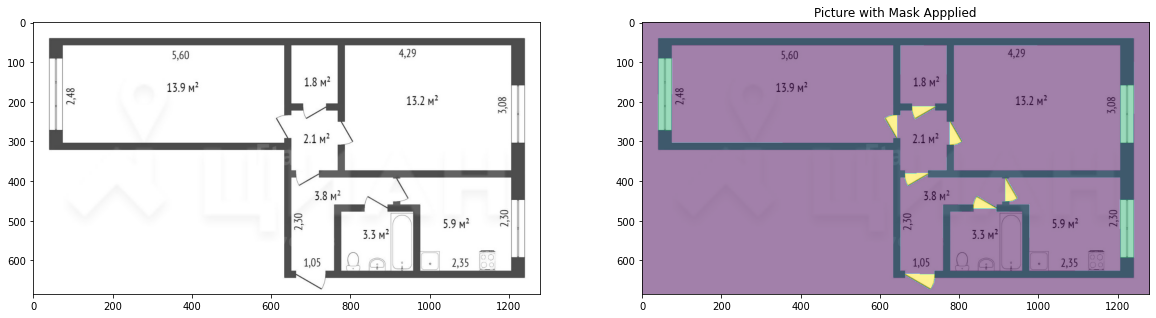

Image Size (850, 800, 3)
Mask Size (850, 800)
images/aug_arrow_1e524791-388c-4b9a-b598-98959ad5aa03.png


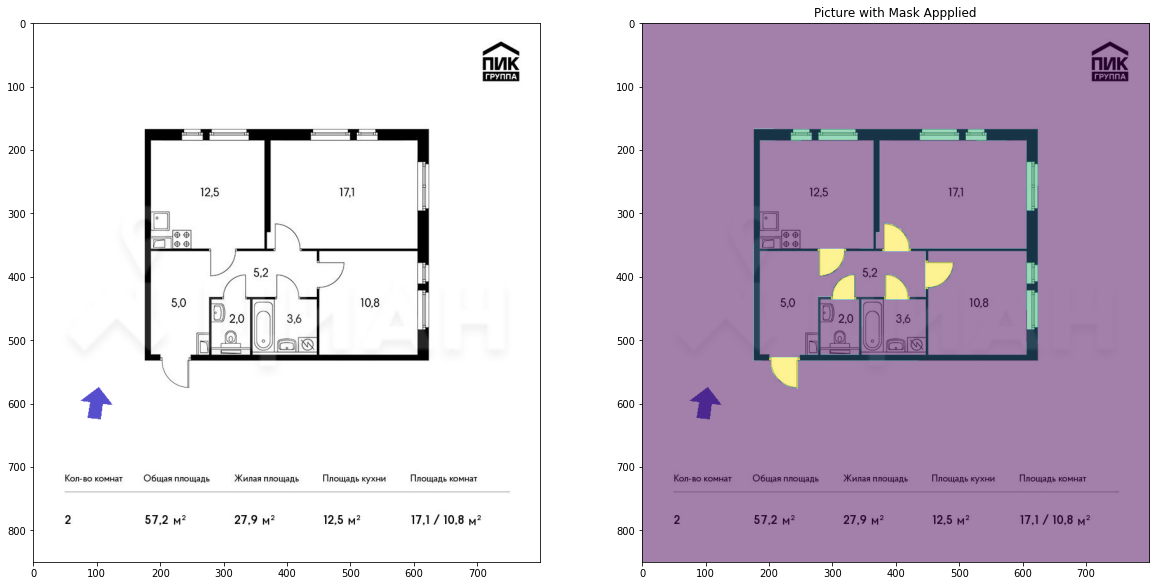

Image Size (850, 800, 3)
Mask Size (850, 800)
images/b4c00a64-3f4c-420d-8338-74f3e5dd810c.png


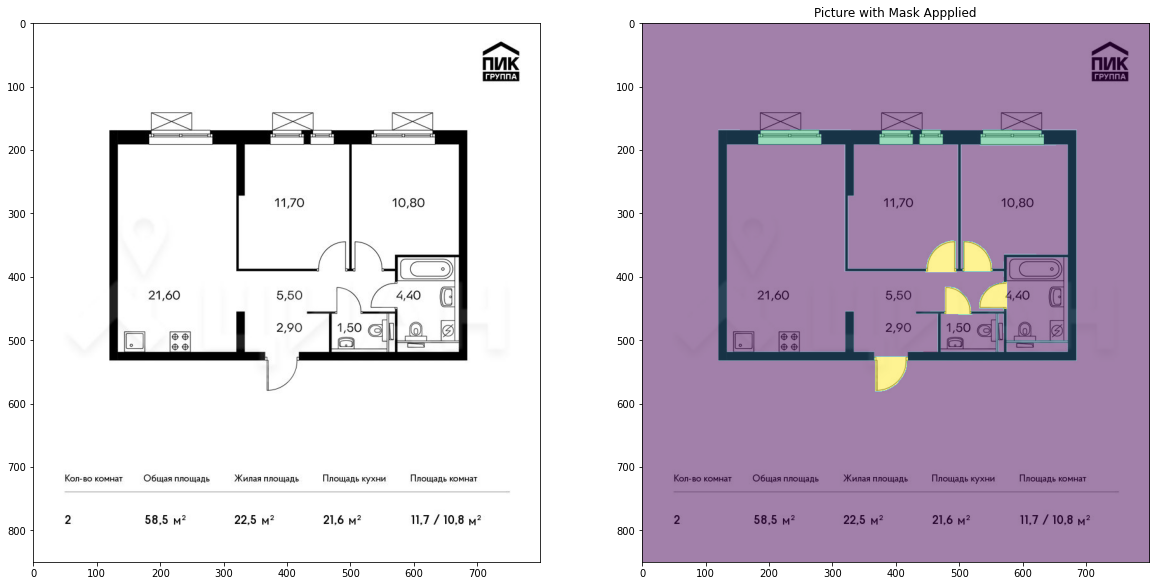

Image Size (697, 914, 3)
Mask Size (697, 914)
images/5fa5a09b-0521-4c44-9a3d-9bc4d1abb0df.png


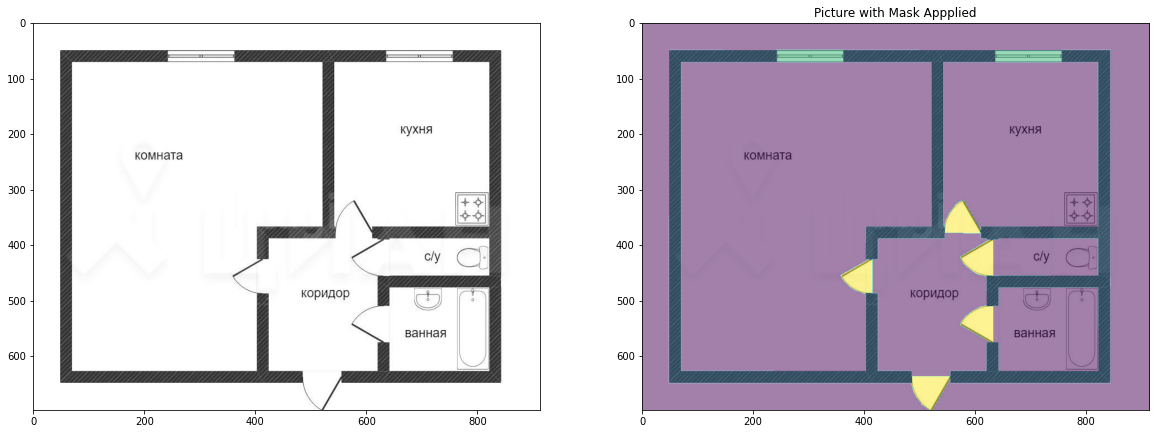

Image Size (494, 432, 3)
Mask Size (494, 432)
images/81537dda-82a2-4ec0-95d2-dab054866b8e.png


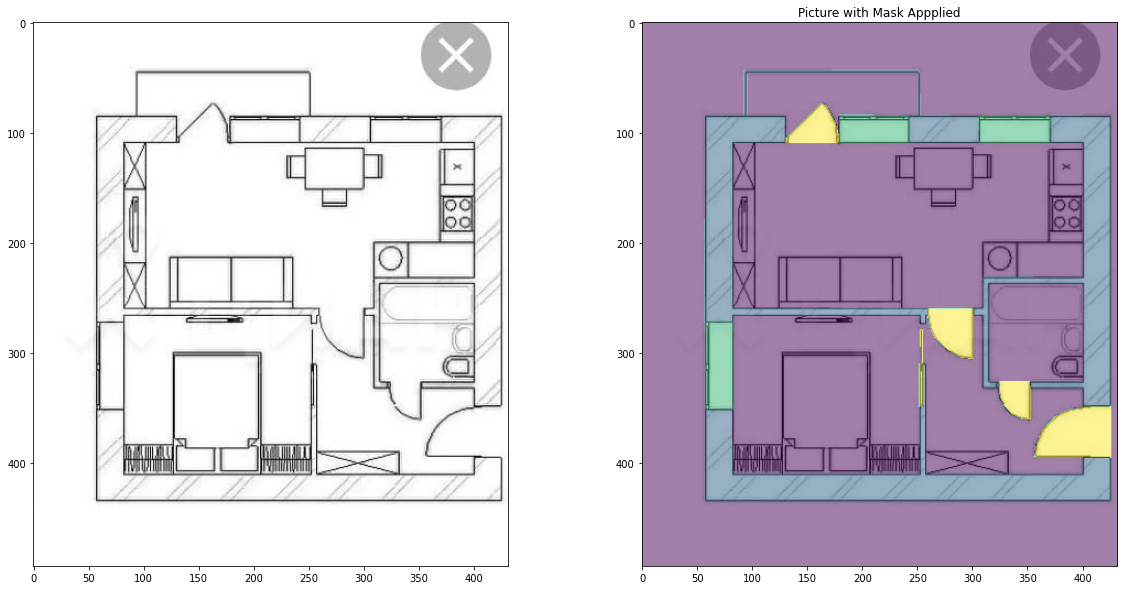

In [11]:
for name in random.sample(list(glob.glob(IMAGE_PATH + '*.png')), 5):
    img = Image.open(name)
    mask = Image.open(MASK_PATH + name.split('/')[-1])

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
    print('Image Size', np.asarray(img).shape)
    print('Mask Size', np.asarray(mask).shape)
    print(name)

    ax1.imshow(img)
    ax2.imshow(img)
    ax2.imshow(mask, alpha=0.5)
    plt.title('Picture with Mask Appplied')
    plt.show()

### Dataset and metrics

In [12]:
class FlatDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, test=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.mean = mean
        self.std = std
        self.test = test
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if not self.test:
            mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
    
            if self.transform is not None:
                aug = self.transform(image=img, mask=mask)
                img = Image.fromarray(aug['image'])
                mask = aug['mask']

            if self.transform is None:
                img = Image.fromarray(img)
                
            t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
            img = t(img)
            mask = torch.from_numpy(mask).long()
                
            return img, mask
        
        else:
            if self.transform is not None:
                aug = self.transform(image=img)
                img = Image.fromarray(aug['image'])
            
            t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
            img = t(img)
            
            return img

In [13]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST),
                     # A.RandomCrop(width=256, height=256, p=0.1),
                     A.ShiftScaleRotate(p=0.1),
                     # A.Transpose(p=0.1),
                     A.HorizontalFlip(p=0.1), 
                     A.VerticalFlip(p=0.1), 
                     # A.RandomRotate90(p=0.3),
                     # A.GridDistortion(p=0.2),
                     A.Blur(blur_limit=3, p=0.2),
                     A.ChannelShuffle(p=0.1),
                     A.RandomBrightnessContrast(0.5,0.2, True, p=0.3),
                     A.GaussNoise(p=0.3),
                     A.ISONoise((0.01, 0.05), (0.1, 0.5), p=0.1),
                     # A.ChannelDropout((1,2), 0, p=0.1)
                     A.RandomShadow((0, 0.5, 1, 1), 5, 5, 5,  p=0.5),
                     A.Downscale(0.05, 0.20, interpolation=0, p=0.2),
                     A.OneOf([
                        # A.OpticalDistortion(p=0.3),
                        A.GridDistortion(p=.1),
                        A.PiecewiseAffine(p=0.3),
                     ], p=0.2),        
                     A.OneOf([
                        A.CLAHE(clip_limit=2),
                        A.Sharpen(),
                        A.IAAEmboss(),
                        A.RandomBrightnessContrast(),            
                    ], p=0.3),
                    A.HueSaturationValue(p=0.3),
                    A.ToGray(p=0.1)
                    ])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = FlatDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train)
val_set = FlatDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val)

#dataloader
batch_size= 16

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)  

/home/matresha/.local/lib/python3.9/site-packages/albumentations/imgaug/transforms.py:174: FutureWarning: This augmentation is deprecated. Please use Emboss instead
  warnings.warn("This augmentation is deprecated. Please use Emboss instead", FutureWarning)


In [14]:
# metrics
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

def mIoU(pred_mask, mask, smooth=1e-10, n_classes=N_CLASSES):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

### Model training

In [15]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)

            image = image_tiles.to(device);
            mask = mask_tiles.to(device);
            
            #forward
            output = model(image)
            loss = criterion(output, mask)

            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
  
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask) 
                    
                    test_loss += loss.item()
            
            #calculation mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [ ]:
max_lr = 1e-3
epoch = 15
weight_decay = 1e-5

model = smp.FPN('resnet34', in_channels=3, classes=N_CLASSES)

criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 1.0, 2.0, 1.0],dtype=torch.float).to('cuda'))

optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.113 
Epoch:1/15.. Train Loss: 0.313.. Val Loss: 0.113.. Train mIoU:0.442.. Val mIoU: 0.641.. Train Acc:0.912.. Val Acc:0.962.. Time: 9.23m


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Loss Decreasing.. 0.113 >> 0.090 
Epoch:2/15.. Train Loss: 0.153.. Val Loss: 0.090.. Train mIoU:0.611.. Val mIoU: 0.732.. Train Acc:0.952.. Val Acc:0.970.. Time: 8.53m


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:3/15.. Train Loss: 0.129.. Val Loss: 0.114.. Train mIoU:0.667.. Val mIoU: 0.745.. Train Acc:0.959.. Val Acc:0.970.. Time: 8.44m


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Loss Decreasing.. 0.114 >> 0.081 
Epoch:4/15.. Train Loss: 0.117.. Val Loss: 0.081.. Train mIoU:0.693.. Val mIoU: 0.768.. Train Acc:0.963.. Val Acc:0.972.. Time: 8.71m


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Loss Decreasing.. 0.081 >> 0.065 
saving model...
Epoch:5/15.. Train Loss: 0.110.. Val Loss: 0.065.. Train mIoU:0.715.. Val mIoU: 0.797.. Train Acc:0.965.. Val Acc:0.979.. Time: 8.64m


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:6/15.. Train Loss: 0.097.. Val Loss: 0.065.. Train mIoU:0.738.. Val mIoU: 0.804.. Train Acc:0.968.. Val Acc:0.979.. Time: 8.47m


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Loss Decreasing.. 0.065 >> 0.060 
Epoch:7/15.. Train Loss: 0.098.. Val Loss: 0.060.. Train mIoU:0.740.. Val mIoU: 0.821.. Train Acc:0.969.. Val Acc:0.980.. Time: 8.78m


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Loss Decreasing.. 0.060 >> 0.055 
Epoch:8/15.. Train Loss: 0.087.. Val Loss: 0.055.. Train mIoU:0.760.. Val mIoU: 0.828.. Train Acc:0.972.. Val Acc:0.982.. Time: 8.69m


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Loss Decreasing.. 0.055 >> 0.055 
Epoch:9/15.. Train Loss: 0.081.. Val Loss: 0.055.. Train mIoU:0.772.. Val mIoU: 0.833.. Train Acc:0.973.. Val Acc:0.981.. Time: 8.95m


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:10/15.. Train Loss: 0.078.. Val Loss: 0.061.. Train mIoU:0.776.. Val mIoU: 0.838.. Train Acc:0.974.. Val Acc:0.981.. Time: 8.65m


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Loss Decreasing.. 0.061 >> 0.052 
Epoch:11/15.. Train Loss: 0.074.. Val Loss: 0.052.. Train mIoU:0.785.. Val mIoU: 0.850.. Train Acc:0.975.. Val Acc:0.984.. Time: 8.70m


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Loss Decreasing.. 0.052 >> 0.049 
saving model...
Epoch:12/15.. Train Loss: 0.070.. Val Loss: 0.049.. Train mIoU:0.796.. Val mIoU: 0.857.. Train Acc:0.976.. Val Acc:0.985.. Time: 8.63m


  0%|          | 0/220 [00:00<?, ?it/s]

In [ ]:
torch.save(model, 'resnet.pt')

### Predict results

In [32]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

def predict_image_mask(model, image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device)
    image=image.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        
        output = model(image)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked

In [33]:
mob_miou = miou_score(model, test_set)
mob_acc = pixel_acc(model, test_set)
print('Test Set mIoU', np.mean(mob_miou))
print('Test Set Pixel Accuracy', np.mean(mob_acc))

NameError: name 'test_set' is not defined

In [32]:
# see validation result
image, mask = test_set[0]
pred_mask, score = predict_image_mask_miou(model, image, mask)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

In [60]:
n_classes = N_CLASSES
def create_df():
    name = []
    for dirname, _, filenames in os.walk('test/'):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))
df_pred = create_df()

In [64]:
t_test = A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST)
pred_set = FlatDataset('test/', MASK_PATH, df_pred['id'].values, mean, std, transform=t_test,  test=True)

In [55]:
# save predicted masks result 
for pr_image, name in pred_set:
    img = cv2.imread('test/' + name)
    pred_mask = predict_image_mask(model, pr_image)
    t_pred = A.Resize(img.shape[0], img.shape[1], interpolation=cv2.INTER_NEAREST)
    aug = t_pred(image=pred_mask.numpy())
    cv2.imwrite('results/masks/' + name, aug['image'])

1062


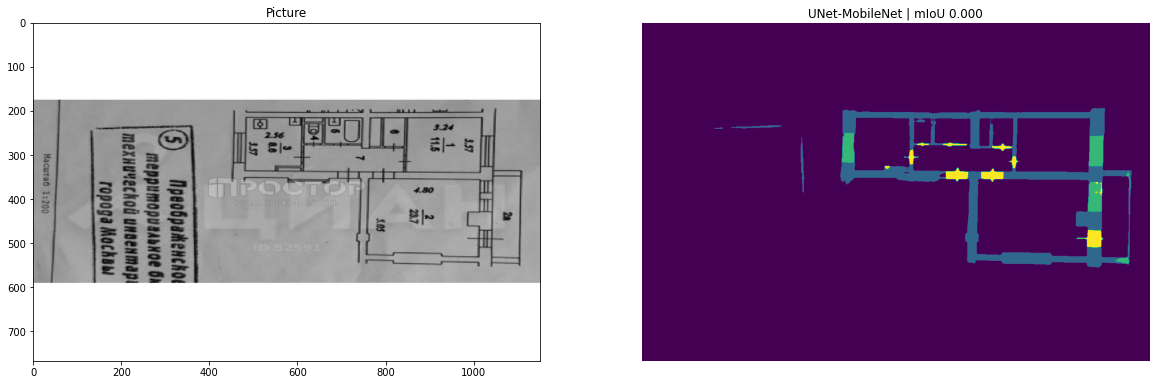

In [60]:
# sample of predict with mask
pr_image, name = pred_set[1445]
print(i)
i +=1

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(pr_image)
ax1.set_title('Picture')

pred_mask = predict_image_mask(model, pr_image)

ax2.imshow(pred_mask)
ax2.set_title('UNet-MobileNet | mIoU {:.3f}'.format(0))
ax2.set_axis_off()